In [1]:
import os
import time
import torch
from PIL import Image
import torchvision
import numpy as np
from tqdm import tqdm
from torch import optim
from scipy.ndimage import zoom
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
import pandas as pd
from utils import * 
from model import SAM_CFFNet

In [2]:
def parse_args():
    import argparse
    parser = argparse.ArgumentParser(description="pytorch SAM_CFFNet training")
    parser.add_argument("--local_rank"     , default = 0, type=int,  help="")
    parser.add_argument("--dataset"        , choices = ["BJL", "L4S", "GVLM"], default="GVLM")
    parser.add_argument("--sam_pretrained_weights", default = None, type=str, help="path to SAM model pretrained weights file")
    parser.add_argument("--encoder_mode"   , default= "l")
    parser.add_argument('--modelname'      , default = 'SAM_CFFNet', type=str, metavar='data', help='model name')
    parser.add_argument("--batch_size"     , default = 8, type=int,  help="")
    parser.add_argument("--num_classes"    , default = 1 + 1, type=int, help="加上背景")
    parser.add_argument('--epochs'         , default = 30, type=int, metavar='N', help='total epochs')
    parser.add_argument('--lr'             , default = 0.0002, type=float, help='initial learning rate')
    parser.add_argument('--lr_min'         , default = 1e-07, type=float)
    parser.add_argument('--inp_size'       , default = 1024, type=float)
    parser.add_argument('--resume'         , default = '/home/mw/work/sam_cffnet', type=str, metavar='PATH')
    parser.add_argument("--device"         , default = 'cpu', type=str,  help="")
    parser.add_argument('--momentum', default=0.9, type=float, metavar='M',help='momentum')

    # args = parser.parse_args()

    args = parser.parse_known_args()[0]

    return args

In [3]:
seed_everything(100)
args = parse_args()

args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
sam_cffnet = SAM_CFFNet(args)
model = sam_cffnet.cuda()

In [7]:
model_weight_path = f"./sam_cffnet_weight/{args.dataset}_best.pth.tar"
weight_dict = torch.load(model_weight_path, map_location='cuda')['state_dict']
model.load_state_dict(weight_dict)

<All keys matched successfully>

In [8]:
_, valid_loader = make_data_loaders(args)
evaluator = Evaluator(2)
test_reselt  = validationing(valid_loader,   model,    0, evaluator, args)

Training_Data : 1977    valing_Data: 710


In [9]:
print(f"*** {args.dataset} Dataset ***")
print(f"Precision: {test_reselt['presion'] * 100:.2f}%")
print(f"Recall   : {test_reselt['recall'] * 100:.2f}%")
print(f"F1 Score : {test_reselt['F1score'] * 100:.2f}%")
print(f"mIoU     : {test_reselt['mIou'] * 100:.2f}%")
print(f"IoU      : {test_reselt['Iou 1'] * 100:.2f}%")

*** GVLM Dataset ***
Precision: 90.31%
Recall   : 91.29%
F1 Score : 90.79%
mIoU     : 83.65%
IoU      : 73.87%


In [10]:
valid_loader_iter = iter(valid_loader)
model = model.eval()

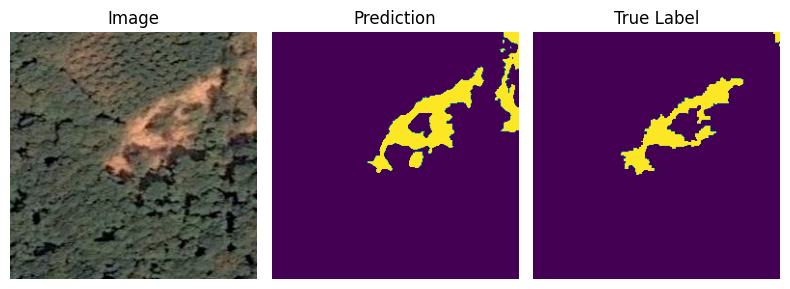

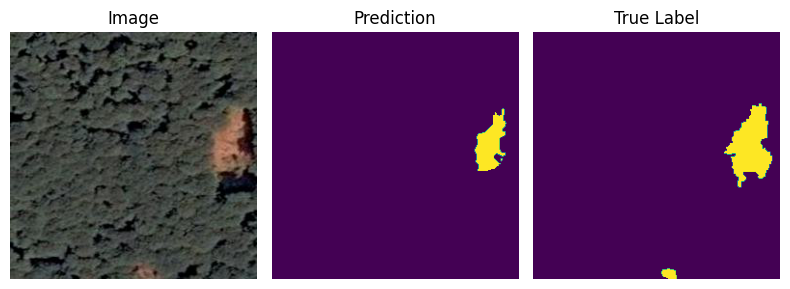

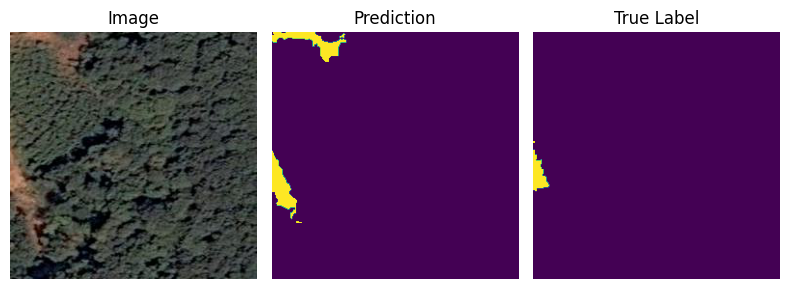

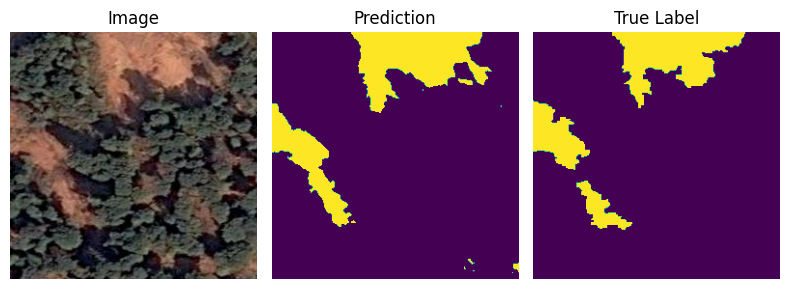

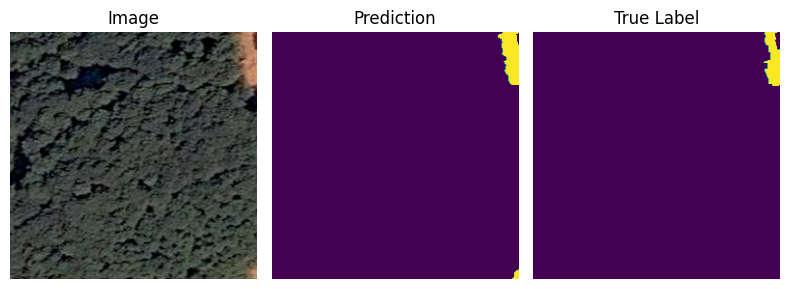

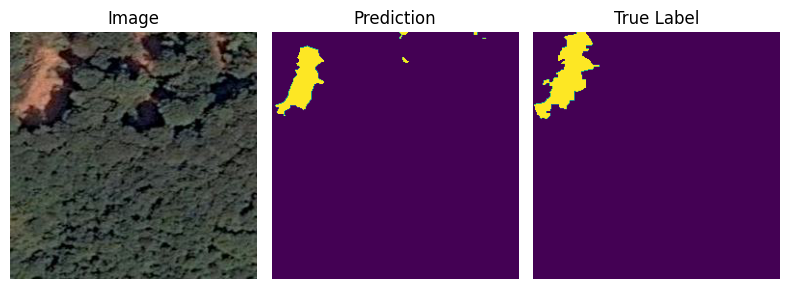

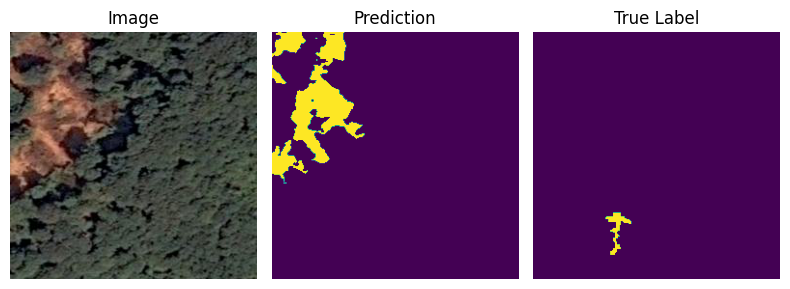

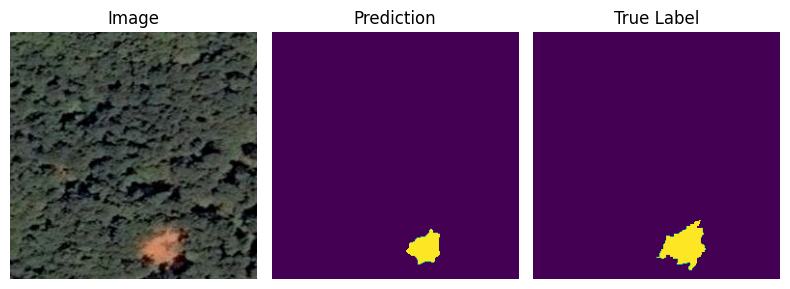

In [11]:
x, y = next(valid_loader_iter)
rgb = x.to(args.device)
with torch.no_grad():
    output = model(rgb.float())
output[output > 0.5] = 1
output[output <= 0.5] = 0
predictions = output.cpu().detach().numpy()
# 可视化预测结果和真实标签
for ii in range(8):
    display_images_with_predictions_and_labels(
        x[ii].detach().numpy(), predictions[ii], y[ii].detach().numpy()
    )